In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Analysis
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import scipy.stats as stats
## Need to use metPy conda env
import metpy.calc as mpc
from metpy.units import units
import time
import pickle


import warnings
warnings.filterwarnings('ignore')

In [2]:

# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds



## Adam's trick to output the budget terms direclty 

In [3]:
start_time = time.time()

saveDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/ProcessedFiles/'

realSfc_allCases          = pickle.load( open( saveDir+"realSfc_allCases_withInterp.p", "rb" ) )

HMGclmDS_localReal        = pickle.load( open( saveDir+"HMGclmDS_localReal.p", "rb" ) )
HTGclmDS_localReal        = pickle.load( open( saveDir+"HTGclmDS_localReal.p", "rb" ) )
HTGclmDS_localReal10      = pickle.load( open( saveDir+"HTGclmDS_localReal10.p", "rb" ) )

HMGclmDS_localRealPatch   = pickle.load( open( saveDir+"HMGclmDS_localRealPatch.p", "rb" ) )
HTGclmDS_localRealPatch   = pickle.load( open( saveDir+"HTGclmDS_localRealPatch.p", "rb" ) )
HTGclmDS_localRealPatch10 = pickle.load( open( saveDir+"HTGclmDS_localRealPatch10.p", "rb" ) )

print('Loaded all the real_sfc pickle files')

# artSfc_allCases        = pickle.load( open( saveDir+"artSfc_allCases_withInterp.p", "rb" ) )
# artSfcMult_allCases    = pickle.load( open( saveDir+"artSfcMult_allCases_withInterp.p", "rb" ) )

# HMGclmDS_localArt        = pickle.load( open( saveDir+"HMGclmDS_localArt.p", "rb" ) )
# HTGclmDS_localArt        = pickle.load( open( saveDir+"HTGclmDS_localArt.p", "rb" ) )
# HTGclmDS_localArt5       = pickle.load( open( saveDir+"HTGclmDS_localArt5.p", "rb" ) )
# HTGclmDS_localArt25      = pickle.load( open( saveDir+"HTGclmDS_localArt25.p", "rb" ) )

# HMGclmDS_localArtPatch   = pickle.load( open( saveDir+"HMGclmDS_localArtPatch.p", "rb" ) )
# HTGclmDS_localArtPatch   = pickle.load( open( saveDir+"HTGclmDS_localArtPatch.p", "rb" ) )

# print('Loaded all the artificial_sfc pickle files')

print('Total elapsed time (sec): ', time.time()-start_time)


Loaded all the real_sfc pickle files
Total elapsed time (sec):  18.859755992889404


In [4]:
## Add other vars to the list

# This set uses theta, not theta_v; and adds outputs of rt'thv' and tau
dataDir      = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/realSfc_buoyancyTau_useTheta/'
caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_plusBuoyancyTau_useTheta_'
caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_plusBuoyancyTau_useTheta_'

yearStrings  = np.asarray(['2015','2016','2017','2018'])

fileCount=0
for iYr in range(len(yearStrings)): 

    fileStart_atm_HMG   = dataDir+caseName_HMG+yearStrings[iYr]+'jja.cam.h0.'
    fileStart_atm_HTG   = dataDir+caseName_HTG+yearStrings[iYr]+'jja.cam.h0.'

    fileName_atm_HMG   = fileStart_atm_HMG+'wp2BudgetTerms.nc'
    fileName_atm_HTG   = fileStart_atm_HTG+'wp2BudgetTerms.nc'
    
        
    with xr.open_dataset(fileName_atm_HMG, decode_times=False) as HMG_camDS:
        HMG_camDS = cesm_correct_time(HMG_camDS)
        HMG_camDS['time'] = HMG_camDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(fileName_atm_HTG, decode_times=False) as HTG_camDS:
        HTG_camDS = cesm_correct_time(HTG_camDS)
        HTG_camDS['time'] = HTG_camDS.indexes['time'].to_datetimeindex()  

            
    # Discard first two days 
    iTimeStart   = np.where(HMG_camDS.time.values >= (HMG_camDS.time.values[0] + np.timedelta64(2,'D')))[0]
    timeArr      = np.arange(iTimeStart[0], len(HMG_camDS.time.values))

    HTG_camDS      = HTG_camDS.isel(time=timeArr)
    HMG_camDS      = HMG_camDS.isel(time=timeArr)


    if fileCount==0:
        HTGcamDS_realSfcExtra   = HTG_camDS
        HMGcamDS_realSfcExtra   = HMG_camDS  
    else: 
        HTGcamDS_realSfcExtra   = xr.concat([HTGcamDS_realSfcExtra,HTG_camDS], dim='time')
        HMGcamDS_realSfcExtra   = xr.concat([HMGcamDS_realSfcExtra,HMG_camDS], dim='time')
            
    fileCount = fileCount+1
    print('Done with file %i of %i '% (fileCount,len(yearStrings)))


Done with file 1 of 4 
Done with file 2 of 4 
Done with file 3 of 4 
Done with file 4 of 4 


In [5]:
## Convert to local times...
HTGcamDS_realSfcExtra_local   = HTGcamDS_realSfcExtra.copy(deep=True)
HMGcamDS_realSfcExtra_local   = HMGcamDS_realSfcExtra.copy(deep=True)

# Confirmed that all the times are identical, so using the same local time arrays
localTimes = HMGcamDS_realSfcExtra_local['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
HTGcamDS_realSfcExtra_local = HTGcamDS_realSfcExtra_local.assign_coords({"time": localTimes})
HMGcamDS_realSfcExtra_local = HMGcamDS_realSfcExtra_local.assign_coords({"time": localTimes})



In [6]:
# Merge into larger dataset
HTGcamDS_localReal   = xr.merge([realSfc_allCases.isel(case=1),   HTGcamDS_realSfcExtra_local])
HMGcamDS_localReal   = xr.merge([realSfc_allCases.isel(case=0),   HMGcamDS_realSfcExtra_local])

In [61]:
# # This version also outputs the buoyancy term, rt'thv', tau, and uses theta (not theta_v) for HTG additions
# dataDirBase   = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/artificialSfc_buoyancyTau_useTheta/'
# caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_artificialSfc_plusBuoyancyTau_useTheta_'
# caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_5mDt_artificialSfc_plusBuoyancyTau_useTheta_'


# yearStrings  = np.asarray(['2015','2016','2017','2018'])
# dateEndFiles = np.asarray([ '-05-31-84585.nc',
#                             '-06-09-56985.nc',
#                             '-06-18-29385.nc',
#                             '-06-27-01785.nc',
#                             '-07-05-60585.nc',
#                             '-07-14-32985.nc',
#                             '-07-23-05385.nc',
#                             '-07-31-64185.nc',
#                             '-08-09-36585.nc',
#                             '-08-18-08985.nc',
#                             '-08-26-67785.nc' ])

# fileCount=0
# for iYr in range(len(yearStrings)): 
#     fileStart_HMG = dataDirBase+caseName_HMG+yearStrings[iYr]+'jja.clm2.h0.'+yearStrings[iYr]
#     fileStart_HTG = dataDirBase+caseName_HTG+yearStrings[iYr]+'jja.clm2.h0.'+yearStrings[iYr]
    
#     fileStartPatch_HMG = dataDirBase+caseName_HMG+yearStrings[iYr]+'jja.clm2.h1.'+yearStrings[iYr]
#     fileStartPatch_HTG = dataDirBase+caseName_HTG+yearStrings[iYr]+'jja.clm2.h1.'+yearStrings[iYr]
    
#     fileStart_atm_HMG = dataDirBase+caseName_HMG+yearStrings[iYr]+'jja.cam.h1.'+yearStrings[iYr]
#     fileStart_atm_HTG = dataDirBase+caseName_HTG+yearStrings[iYr]+'jja.cam.h1.'+yearStrings[iYr]
    
    
#     for iFile in range(len(dateEndFiles)):
#         fileName_HMG = fileStart_HMG+dateEndFiles[iFile]
#         fileName_HTG = fileStart_HTG+dateEndFiles[iFile]
                                                                                          
#         fileNamePatch_HMG = fileStartPatch_HMG+dateEndFiles[iFile]
#         fileNamePatch_HTG = fileStartPatch_HTG+dateEndFiles[iFile]
        
#         fileName_atm_HMG = fileStart_atm_HMG+dateEndFiles[iFile]
#         fileName_atm_HTG = fileStart_atm_HTG+dateEndFiles[iFile]
        
        
#         with xr.open_dataset(fileName_atm_HMG, decode_times=False) as HMG_camDS:
#             HMG_camDS = cesm_correct_time(HMG_camDS)
#             HMG_camDS['time'] = HMG_camDS.indexes['time'].to_datetimeindex()
#         with xr.open_dataset(fileName_atm_HTG, decode_times=False) as HTG_camDS:
#             HTG_camDS = cesm_correct_time(HTG_camDS)
#             HTG_camDS['time'] = HTG_camDS.indexes['time'].to_datetimeindex()  
            
#         with xr.open_dataset(fileName_HMG, decode_times=True) as HMG_clmDS: 
#             HMG_clmDS['time'] = HTG_camDS['time']
#         with xr.open_dataset(fileName_HTG, decode_times=True) as HTG_clmDS: 
#             HTG_clmDS['time'] = HTG_camDS['time']
            
#         with xr.open_dataset(fileNamePatch_HMG, decode_times=True) as HMG_clmPatchDS: 
#             HMG_clmPatchDS['time'] = HTG_camDS['time']
#         with xr.open_dataset(fileNamePatch_HTG, decode_times=True) as HTG_clmPatchDS: 
#             HTG_clmPatchDS['time'] = HTG_camDS['time']   
                  
          
#         # Discard the first two days if iFile == 0  
#         if iFile==0:
#             iTimeStart   = np.where(HMG_clmDS.time.values >= (HMG_clmDS.time.values[0] + np.timedelta64(2,'D')))[0]
#             timeArr      = np.arange(iTimeStart[0], len(HMG_clmDS.time.values))

#             HTG_camDS      = HTG_camDS.isel(time=timeArr)
#             HMG_camDS      = HMG_camDS.isel(time=timeArr)
#             HTG_clmDS      = HTG_clmDS.isel(time=timeArr)
#             HMG_clmDS      = HMG_clmDS.isel(time=timeArr)
#             HTG_clmPatchDS = HTG_clmPatchDS.isel(time=timeArr)
#             HMG_clmPatchDS = HMG_clmPatchDS.isel(time=timeArr)


#         if fileCount==0:
#             HTGcamDS_art = HTG_camDS
#             HMGcamDS_art = HMG_camDS
            
#             HTGclmDS_art = HTG_clmDS
#             HMGclmDS_art = HMG_clmDS
            
#             HTGclmDS_artPatch = HTG_clmPatchDS
#             HMGclmDS_artPatch = HMG_clmPatchDS

            
#         else: 
#             HTGcamDS_art = xr.concat([HTGcamDS_art,HTG_camDS], dim='time')
#             HMGcamDS_art = xr.concat([HMGcamDS_art,HMG_camDS], dim='time')
            
#             HTGclmDS_art = xr.concat([HTGclmDS_art,HTG_clmDS], dim='time', data_vars='minimal')
#             HMGclmDS_art = xr.concat([HMGclmDS_art,HMG_clmDS], dim='time', data_vars='minimal')
            
#             HTGclmDS_artPatch = xr.concat([HTGclmDS_artPatch,HTG_clmPatchDS], dim='time', data_vars='minimal')
#             HMGclmDS_artPatch = xr.concat([HMGclmDS_artPatch,HMG_clmPatchDS], dim='time', data_vars='minimal')
        
#         fileCount = fileCount+1
#         print('Done with file %i of %i '% (fileCount,len(yearStrings)*len(dateEndFiles)))



Done with file 1 of 44 
Done with file 2 of 44 
Done with file 3 of 44 
Done with file 4 of 44 
Done with file 5 of 44 
Done with file 6 of 44 
Done with file 7 of 44 
Done with file 8 of 44 
Done with file 9 of 44 
Done with file 10 of 44 
Done with file 11 of 44 
Done with file 12 of 44 
Done with file 13 of 44 
Done with file 14 of 44 
Done with file 15 of 44 
Done with file 16 of 44 
Done with file 17 of 44 
Done with file 18 of 44 
Done with file 19 of 44 
Done with file 20 of 44 
Done with file 21 of 44 
Done with file 22 of 44 
Done with file 23 of 44 
Done with file 24 of 44 
Done with file 25 of 44 
Done with file 26 of 44 
Done with file 27 of 44 
Done with file 28 of 44 
Done with file 29 of 44 
Done with file 30 of 44 
Done with file 31 of 44 
Done with file 32 of 44 
Done with file 33 of 44 
Done with file 34 of 44 
Done with file 35 of 44 
Done with file 36 of 44 
Done with file 37 of 44 
Done with file 38 of 44 
Done with file 39 of 44 
Done with file 40 of 44 
Done with

In [ ]:
# ## Add other vars to the list

# # This set uses theta, not theta_v; and adds outputs of rt'thv' and tau
# dataDir   = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/artificialSfc_buoyancyTau_useTheta/'
# caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_artificialSfc_plusBuoyancyTau_useTheta_'
# caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_5mDt_artificialSfc_plusBuoyancyTau_useTheta_'

# yearStrings  = np.asarray(['2015','2016','2017','2018'])

# fileCount=0
# for iYr in range(len(yearStrings)): 

    
#     fileStart_atm_HMG = dataDir+caseName_HMG+yearStrings[iYr]+'jja.cam.h0.'
#     fileStart_atm_HTG = dataDir+caseName_HTG+yearStrings[iYr]+'jja.cam.h0.'

#     fileName_atm_HMG = fileStart_atm_HMG+'wp2BudgetTerms.nc'
#     fileName_atm_HTG = fileStart_atm_HTG+'wp2BudgetTerms.nc'
    
        
#     with xr.open_dataset(fileName_atm_HMG, decode_times=False) as HMG_camDS:
#         HMG_camDS = cesm_correct_time(HMG_camDS)
#         HMG_camDS['time'] = HMG_camDS.indexes['time'].to_datetimeindex()
#     with xr.open_dataset(fileName_atm_HTG, decode_times=False) as HTG_camDS:
#         HTG_camDS = cesm_correct_time(HTG_camDS)
#         HTG_camDS['time'] = HTG_camDS.indexes['time'].to_datetimeindex()  
            
#     # Discard first two days 
#     iTimeStart   = np.where(HMG_camDS.time.values >= (HMG_camDS.time.values[0] + np.timedelta64(2,'D')))[0]
#     timeArr      = np.arange(iTimeStart[0], len(HMG_camDS.time.values))

#     HTG_camDS      = HTG_camDS.isel(time=timeArr)
#     HMG_camDS      = HMG_camDS.isel(time=timeArr)


#     if fileCount==0:
#         HTGcamDS_artExtra = HTG_camDS
#         HMGcamDS_artExtra = HMG_camDS            
#     else: 
#         HTGcamDS_artExtra = xr.concat([HTGcamDS_artExtra,HTG_camDS], dim='time')
#         HMGcamDS_artExtra = xr.concat([HMGcamDS_artExtra,HMG_camDS], dim='time')
            
#     fileCount = fileCount+1
#     print('Done with file %i of %i '% (fileCount,len(yearStrings)))


In [ ]:
# ## Convert to local times...
# HTGcamDS_artExtra_local   = HTGcamDS_artExtra.copy(deep=True)
# HMGcamDS_artExtra_local   = HMGcamDS_artExtra.copy(deep=True)

# # Confirmed that all the times are identical, so using the same local time arrays
# localTimes = HTGcamDS_artExtra_local['time'].values - np.timedelta64(5,'h')

# # Replace time dimension with local time
# HTGcamDS_artExtra_local = HTGcamDS_artExtra_local.assign_coords({"time": localTimes})
# HMGcamDS_artExtra_local = HMGcamDS_artExtra_local.assign_coords({"time": localTimes})



In [ ]:
# # Merge into larger dataset
# HTGcamDS_localArt = xr.merge([artSfc_allCases.isel(case=1), HTGcamDS_artExtra_local])
# HMGcamDS_localArt = xr.merge([artSfc_allCases.isel(case=0), HMGcamDS_artExtra_local])

In [82]:
# ## Convert to local times...
# HTGcamDS_local       = HTGcamDS_art.copy(deep=True)
# HMGcamDS_local       = HMGcamDS_art.copy(deep=True)

# HTGcamDS_localReal   = HTGcamDS_realSfc.copy(deep=True)
# HMGcamDS_localReal   = HMGcamDS_realSfc.copy(deep=True)

# # Confirmed that all the times are identical, so using the same local time arrays
# localTimes = HMGcamDS_local['time'].values - np.timedelta64(5,'h')

# # Replace time dimension with local time
# HTGcamDS_local = HTGcamDS_local.assign_coords({"time": localTimes})
# HMGcamDS_local = HMGcamDS_local.assign_coords({"time": localTimes})

# HTGcamDS_localReal = HTGcamDS_localReal.assign_coords({"time": localTimes})
# HMGcamDS_localReal = HMGcamDS_localReal.assign_coords({"time": localTimes})



In [10]:
## Add in TKE 

HMGcamDS_localReal['TKE']  = (('time','ilev','lat,','lon'),
                   0.5*(HMGcamDS_localReal['UP2_CLUBB']+HMGcamDS_localReal['VP2_CLUBB']+HMGcamDS_localReal['WP2_CLUBB']))  
HTGcamDS_localReal['TKE']  = (('time','ilev','lat,','lon'),
                   0.5*(HTGcamDS_localReal['UP2_CLUBB']+HTGcamDS_localReal['VP2_CLUBB']+HTGcamDS_localReal['WP2_CLUBB'])) 

# HTGcamDS_localReal10['TKE']  = (('time','ilev','lat,','lon'),
#                    0.5*(HTGcamDS_localReal10['UP2_CLUBB']+HTGcamDS_localReal10['VP2_CLUBB']+HTGcamDS_localReal10['WP2_CLUBB'])) 


HMGcamDS_localArt['TKE']  = (('time','ilev','lat,','lon'),
                   0.5*(HMGcamDS_localArt['UP2_CLUBB']+HMGcamDS_localArt['VP2_CLUBB']+HMGcamDS_localArt['WP2_CLUBB']))  
HTGcamDS_localArt['TKE']  = (('time','ilev','lat,','lon'),
                   0.5*(HTGcamDS_localArt['UP2_CLUBB']+HTGcamDS_localArt['VP2_CLUBB']+HTGcamDS_localArt['WP2_CLUBB'])) 


# HTGcamDS_localArt5['TKE']  = (('time','ilev','lat,','lon'),
#                    0.5*(HTGcamDS_localArt5['UP2_CLUBB']+HTGcamDS_localArt5['VP2_CLUBB']+HTGcamDS_localArt5['WP2_CLUBB'])) 

# HTGcamDS_localArt25['TKE']  = (('time','ilev','lat,','lon'),
#                    0.5*(HTGcamDS_localArt25['UP2_CLUBB']+HTGcamDS_localArt25['VP2_CLUBB']+HTGcamDS_localArt25['WP2_CLUBB'])) 




HMGcamDS_localReal['TKE'].attrs['units']   = 'm2/s2'
HTGcamDS_localReal['TKE'].attrs['units']   = 'm2/s2'
# HTGcamDS_localReal10['TKE'].attrs['units'] = 'm2/s2'

HMGcamDS_localArt['TKE'].attrs['units'] = 'm2/s2'
HTGcamDS_localArt['TKE'].attrs['units'] = 'm2/s2'
# HTGcamDS_localArt5['TKE'].attrs['units']  = 'm2/s2'
# HTGcamDS_localArt25['TKE'].attrs['units'] = 'm2/s2'


HMGcamDS_localReal['TKE'].attrs['long_name']   = 'Turbulent Kinetic Energy'
HTGcamDS_localReal['TKE'].attrs['long_name']   = 'Turbulent Kinetic Energy'
# HTGcamDS_localReal10['TKE'].attrs['long_name'] = 'Turbulent Kinetic Energy'

HMGcamDS_localArt['TKE'].attrs['long_name'] = 'Turbulent Kinetic Energy'
HTGcamDS_localArt['TKE'].attrs['long_name'] = 'Turbulent Kinetic Energy'
# HTGcamDS_localArt5['TKE'].attrs['long_name'] = 'Turbulent Kinetic Energy'
# HTGcamDS_localArt25['TKE'].attrs['long_name'] = 'Turbulent Kinetic Energy'



In [7]:
# Add month_day index to arrays
month_day_idx                      = pd.MultiIndex.from_arrays([HMGclmDS_localReal['time.year'].values,
                                                                HMGclmDS_localReal['time.month'].values, 
                                                                HMGclmDS_localReal['time.day'].values])



HTGcamDS_localReal.coords['year_month_day'] = ('time', month_day_idx)
HMGcamDS_localReal.coords['year_month_day'] = ('time', month_day_idx)

# HTGcamDS_localArt.coords['year_month_day'] = ('time', month_day_idx)
# HMGcamDS_localArt.coords['year_month_day'] = ('time', month_day_idx)


### Identify classes of days

In [8]:
'''
Find all the times in the full array (20m dt) that line up with the day classifications above. 
'''
def getTimes_basedOnDates(fullDS, matchDates):
    iTimes = []
    
    for iTime in range(len(matchDatesDS.year_month_day.values)):
        iKeepTimes = np.where((fullDS['time.year'] ==matchDates.year_month_day_level_0.values[iTime]) &
                              (fullDS['time.month']==matchDates.year_month_day_level_1.values[iTime]) & 
                              (fullDS['time.day']  ==matchDates.year_month_day_level_2.values[iTime]))[0]    
        iTimes = np.append(iTimes, iKeepTimes).astype(int)
    
    # Now select only those times in the local time array
    DS_dayClass = fullDS.isel(time=iTimes)
    
    return(DS_dayClass)


In [9]:
## Read in my spread sheet of sensitive days

#filePath = '/Users/mdfowler/Documents/Analysis/CLASP/CSS_15-18_Finley.csv'
# filePath = '/Users/mdfowler/Documents/Analysis/CLASP/SensitiveDaysToHTG_LWP.csv'
filePath = '/Users/mdfowler/Documents/Analysis/CLASP/SensitiveDaysToHTG_PBLH.csv'

cssDF    = pd.read_csv(filePath, header=0, usecols=[0,1], names=['pos', 'neg'])

# Get dates for LWP positive days:
cssDF.pos = pd.to_datetime(cssDF.pos[0:15], format="%m/%d/%y")
cssDF.neg = pd.to_datetime(cssDF.neg[0:19], format="%m/%d/%y")

# Turn into an xarray dataset (more familiar with that)
cssDS   = cssDF.to_xarray()


In [10]:
numDays_highPct = len(np.where(np.isfinite(cssDS['pos.month']))[0])
numDays_lowPct  = len(np.where(np.isfinite(cssDS['neg.month']))[0])
print('Number of days with highPct: ', numDays_highPct)
print('Number of days with lowPct:  ', numDays_lowPct)

iTimes_highPct = []
for iTime in range(numDays_highPct):
    iKeepTimes = np.where((HMGcamDS_localReal['time.year'] ==cssDS['pos.year'].values[iTime]) &
                          (HMGcamDS_localReal['time.month']==cssDS['pos.month'].values[iTime]) & 
                          (HMGcamDS_localReal['time.day']  ==cssDS['pos.day'].values[iTime]))[0]    
    iTimes_highPct = np.append(iTimes_highPct, iKeepTimes).astype(int)

# Now select only those times in the local time array
HMGcamDS_localReal_highPct = HMGcamDS_localReal.isel(time=iTimes_highPct)
HTGcamDS_localReal_highPct = HTGcamDS_localReal.isel(time=iTimes_highPct)


iTimes_lowPct = []
for iTime in range(numDays_lowPct):
    iKeepTimes = np.where((HMGcamDS_localReal['time.year'] ==cssDS['neg.year'].values[iTime]) &
                          (HMGcamDS_localReal['time.month']==cssDS['neg.month'].values[iTime]) & 
                          (HMGcamDS_localReal['time.day']  ==cssDS['neg.day'].values[iTime]))[0]    
    iTimes_lowPct = np.append(iTimes_lowPct, iKeepTimes).astype(int)

# Now select only those times in the local time array
HMGcamDS_localReal_lowPct = HMGcamDS_localReal.isel(time=iTimes_lowPct)
HTGcamDS_localReal_lowPct = HTGcamDS_localReal.isel(time=iTimes_lowPct)


Number of days with highPct:  13
Number of days with lowPct:   19


In [11]:
## Plot budget terms 

def wp2_budget_plot(HMGds,HTGds,startHr,endHr,xmax,xmin):
    
    # ------- dDry days ----------
    iTimeSel_dDryHMG = np.where((HMGds["time.hour"].values>=startHr) & 
                                (HMGds["time.hour"].values<=endHr))[0]
    iTimeSel_dDryHTG = np.where((HTGds["time.hour"].values>=startHr) & 
                                (HTGds["time.hour"].values<=endHr))[0]


    hourlyMean_dDryTimeSel_HMG = HMGds.isel(time=iTimeSel_dDryHMG).mean(dim='time')
    hourlyMean_dDryTimeSel_HTG = HTGds.isel(time=iTimeSel_dDryHTG).mean(dim='time')


    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))


    meanAdvHMG        = hourlyMean_dDryTimeSel_HMG['wp2_ma'].values[:,0,0]
    turbTranspHMG     = hourlyMean_dDryTimeSel_HMG['wp2_ta'].values[:,0,0]
    accumHMG          = hourlyMean_dDryTimeSel_HMG['wp2_ac'].values[:,0,0]
    buoyProdHMG       = hourlyMean_dDryTimeSel_HMG['wp2_bp'].values[:,0,0]
    
    press1HMG         = hourlyMean_dDryTimeSel_HMG['wp2_pr1'].values[:,0,0]
    press2HMG         = hourlyMean_dDryTimeSel_HMG['wp2_pr2'].values[:,0,0]
    press3HMG         = hourlyMean_dDryTimeSel_HMG['wp2_pr3'].values[:,0,0]
    pressureApproxHMG = press1HMG+press2HMG+press3HMG
    
    dissipation1HMG    = hourlyMean_dDryTimeSel_HMG['wp2_dp1'].values[:,0,0]
    dissipation2HMG    = hourlyMean_dDryTimeSel_HMG['wp2_dp2'].values[:,0,0]
    dissipationHMG     = dissipation1HMG + dissipation2HMG

    dwprtpdtHMG = hourlyMean_dDryTimeSel_HMG['wp2_bt'].values[:,0,0]
    sumTermsHMG = meanAdvHMG + turbTranspHMG  + accumHMG + buoyProdHMG + pressureApproxHMG + dissipationHMG

    residualHMG = dwprtpdtHMG - sumTermsHMG

    
    

    meanAdvHTG        = hourlyMean_dDryTimeSel_HTG['wp2_ma'].values[:,0,0]
    turbTranspHTG     = hourlyMean_dDryTimeSel_HTG['wp2_ta'].values[:,0,0]
    accumHTG          = hourlyMean_dDryTimeSel_HTG['wp2_ac'].values[:,0,0]
    buoyProdHTG       = hourlyMean_dDryTimeSel_HTG['wp2_bp'].values[:,0,0]
    
    press1HTG         = hourlyMean_dDryTimeSel_HTG['wp2_pr1'].values[:,0,0]
    press2HTG         = hourlyMean_dDryTimeSel_HTG['wp2_pr2'].values[:,0,0]
    press3HTG         = hourlyMean_dDryTimeSel_HTG['wp2_pr3'].values[:,0,0]
    pressureApproxHTG = press1HTG+press2HTG+press3HTG
    
    dissipation1HTG    = hourlyMean_dDryTimeSel_HTG['wp2_dp1'].values[:,0,0]
    dissipation2HTG    = hourlyMean_dDryTimeSel_HTG['wp2_dp2'].values[:,0,0]
    dissipationHTG     = dissipation1HTG + dissipation2HTG

    dwprtpdtHTG = hourlyMean_dDryTimeSel_HTG['wp2_bt'].values[:,0,0]
    sumTermsHTG = meanAdvHTG + turbTranspHTG + accumHTG + buoyProdHTG + pressureApproxHTG + dissipationHTG

    residualHTG = dwprtpdtHTG - sumTermsHTG
    
    
    fig,axs = plt.subplots(1,3, figsize=(15,4))
    axs = axs.ravel()

    colorsList = np.asarray(['firebrick','sandybrown','olivedrab','limegreen','lightseagreen','royalblue','darkviolet'])

    axs[0].plot(meanAdvHMG[0:-1],        HMGds.ilev.values[0:-1], color=colorsList[0], label='meanAdv')
    axs[0].plot(turbTranspHMG[0:-1],     HMGds.ilev.values[0:-1], color=colorsList[1], label='turbTransp')
    axs[0].plot(accumHMG[0:-1],          HMGds.ilev.values[0:-1], color=colorsList[3], label='accum')
    axs[0].plot(buoyProdHMG[0:-1],       HMGds.ilev.values[0:-1], color=colorsList[4], label='buoyProd')
    axs[0].plot(pressureApproxHMG[0:-1], HMGds.ilev.values[0:-1], color=colorsList[5], label='pressureTerms')
    axs[0].plot(dissipationHMG[0:-1],    HMGds.ilev.values[0:-1], color=colorsList[6], label='dissipation')
    # axs[0].plot(residualHMG[0:-1],       HMGcamDS_local.ilev.values[0:-1],'ko-', label='residual')

    axs[1].plot(meanAdvHTG[0:-1],        HTGds.ilev.values[0:-1], color=colorsList[0], label='meanAdv')
    axs[1].plot(turbTranspHTG[0:-1],     HTGds.ilev.values[0:-1], color=colorsList[1], label='turbTransp')
    axs[1].plot(accumHTG[0:-1],          HTGds.ilev.values[0:-1], color=colorsList[3], label='accum')
    axs[1].plot(buoyProdHTG[0:-1],       HTGds.ilev.values[0:-1], color=colorsList[4], label='buoyProd')
    axs[1].plot(pressureApproxHTG[0:-1], HTGds.ilev.values[0:-1], color=colorsList[5], label='pressureTerms')
    axs[1].plot(dissipationHTG[0:-1],    HTGds.ilev.values[0:-1], color=colorsList[6], label='dissipation')
    # axs[0].plot(residualHMG[0:-1],       HMGcamDS_local.ilev.values[0:-1],'ko-', label='residual')


    # Plot difference
    axs[2].plot(meanAdvHTG[0:-1]-meanAdvHMG[0:-1],              HTGds.ilev.values[0:-1], color=colorsList[0], label='meanAdv')
    axs[2].plot(turbTranspHTG[0:-1]-turbTranspHMG[0:-1],        HTGds.ilev.values[0:-1], color=colorsList[1], label='turbTransp')
    axs[2].plot(accumHTG[0:-1]-accumHMG[0:-1],                  HTGds.ilev.values[0:-1], color=colorsList[3], label='accum')
    axs[2].plot(buoyProdHTG[0:-1]-buoyProdHMG[0:-1],            HTGds.ilev.values[0:-1], color=colorsList[4], label='buoyProd')
    axs[2].plot(pressureApproxHTG[0:-1]-pressureApproxHMG[0:-1], HTGds.ilev.values[0:-1], color=colorsList[5], label='pressureTerms')
    axs[2].plot(dissipationHTG[0:-1]-dissipationHMG[0:-1],      HTGds.ilev.values[0:-1], color=colorsList[6], label='dissipation')
    
    # Consistent settings across subplots 
    axs[0].set_ylim([700,1000])
    axs[0].set_xlim([xmin,xmax])
    axs[0].invert_yaxis()
    axs[0].legend()
    axs[0].set_title('HMG wp2 budget')

    axs[1].set_ylim([700,1000])
    axs[1].set_xlim([xmin,xmax])
    axs[1].invert_yaxis()
    axs[1].legend()
    axs[1].set_title('HTG wp2 budget')

    axs[2].set_ylim([700,1000])
    axs[2].set_xlim([xmin,xmax])
    axs[2].invert_yaxis()
    axs[2].legend()
    axs[2].set_title('HTG-HMG wp2 budget')
    
    
    axs[0].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[1].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[2].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    
    axs[0].grid()
    axs[1].grid()
    axs[2].grid()
    
    return




Means computed over the inclusive period of 12 to 15.


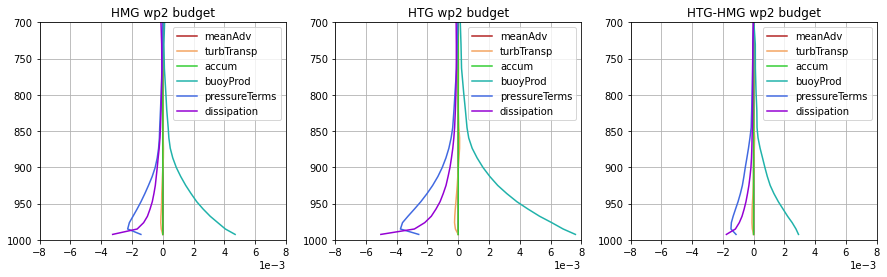

In [12]:
## Artificial surface:
#   TKE decreases most stronly overnight, from maybe 1a to 8a
startHr = 12
endHr   = 15
wp2_budget_plot(HMGcamDS_localReal_highPct, HTGcamDS_localReal_highPct,
                startHr,endHr,0.008,-0.008)


Means computed over the inclusive period of 12 to 15.


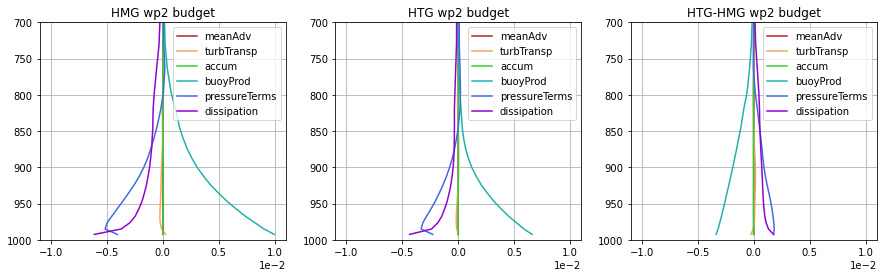

In [13]:
## Artificial surface:
#   TKE decreases most stronly overnight, from maybe 1a to 8a
startHr = 12
endHr   = 15
wp2_budget_plot(HMGcamDS_localReal_lowPct,
                HTGcamDS_localReal_lowPct,
                startHr,endHr,0.011,-0.011)


## WPRTP budget?

In [14]:
## Add other vars to the list

# This set uses theta, not theta_v; and adds outputs of rt'thv' and tau
dataDir      = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/realSfc_buoyancyTau_useTheta/'
caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_plusBuoyancyTau_useTheta_'
caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_plusBuoyancyTau_useTheta_'

yearStrings  = np.asarray(['2015','2016','2017','2018'])

fileCount=0
for iYr in range(len(yearStrings)): 

    fileStart_atm_HMG   = dataDir+caseName_HMG+yearStrings[iYr]+'jja.cam.h0.'
    fileStart_atm_HTG   = dataDir+caseName_HTG+yearStrings[iYr]+'jja.cam.h0.'

    fileName_atm_HMG   = fileStart_atm_HMG+'ExtraVarsAndBudget.nc'
    fileName_atm_HTG   = fileStart_atm_HTG+'ExtraVarsAndBudget.nc'
    
        
    with xr.open_dataset(fileName_atm_HMG, decode_times=False) as HMG_camDS:
        HMG_camDS = cesm_correct_time(HMG_camDS)
        HMG_camDS['time'] = HMG_camDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(fileName_atm_HTG, decode_times=False) as HTG_camDS:
        HTG_camDS = cesm_correct_time(HTG_camDS)
        HTG_camDS['time'] = HTG_camDS.indexes['time'].to_datetimeindex()  

            
    # Discard first two days 
    iTimeStart   = np.where(HMG_camDS.time.values >= (HMG_camDS.time.values[0] + np.timedelta64(2,'D')))[0]
    timeArr      = np.arange(iTimeStart[0], len(HMG_camDS.time.values))

    HTG_camDS      = HTG_camDS.isel(time=timeArr)
    HMG_camDS      = HMG_camDS.isel(time=timeArr)


    if fileCount==0:
        HTGcamDS_realSfcExtra   = HTG_camDS
        HMGcamDS_realSfcExtra   = HMG_camDS  
    else: 
        HTGcamDS_realSfcExtra   = xr.concat([HTGcamDS_realSfcExtra,HTG_camDS], dim='time')
        HMGcamDS_realSfcExtra   = xr.concat([HMGcamDS_realSfcExtra,HMG_camDS], dim='time')
            
    fileCount = fileCount+1
    print('Done with file %i of %i '% (fileCount,len(yearStrings)))


Done with file 1 of 4 
Done with file 2 of 4 
Done with file 3 of 4 
Done with file 4 of 4 


In [15]:
## Convert to local times...
HTGcamDS_realSfcExtra_local   = HTGcamDS_realSfcExtra.copy(deep=True)
HMGcamDS_realSfcExtra_local   = HMGcamDS_realSfcExtra.copy(deep=True)

# Confirmed that all the times are identical, so using the same local time arrays
localTimes = HMGcamDS_realSfcExtra_local['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
HTGcamDS_realSfcExtra_local = HTGcamDS_realSfcExtra_local.assign_coords({"time": localTimes})
HMGcamDS_realSfcExtra_local = HMGcamDS_realSfcExtra_local.assign_coords({"time": localTimes})



In [16]:
# Merge into larger dataset
HTGcamDS_localReal   = xr.merge([realSfc_allCases.isel(case=1),   HTGcamDS_realSfcExtra_local])
HMGcamDS_localReal   = xr.merge([realSfc_allCases.isel(case=0),   HMGcamDS_realSfcExtra_local])

In [17]:
'''
Find all the times in the full array (20m dt) that line up with the day classifications above. 
'''
def getTimes_basedOnDates(fullDS, matchDates):
    iTimes = []
    
    for iTime in range(len(matchDatesDS.year_month_day.values)):
        iKeepTimes = np.where((fullDS['time.year'] ==matchDates.year_month_day_level_0.values[iTime]) &
                              (fullDS['time.month']==matchDates.year_month_day_level_1.values[iTime]) & 
                              (fullDS['time.day']  ==matchDates.year_month_day_level_2.values[iTime]))[0]    
        iTimes = np.append(iTimes, iKeepTimes).astype(int)
    
    # Now select only those times in the local time array
    DS_dayClass = fullDS.isel(time=iTimes)
    
    return(DS_dayClass)


In [18]:
## Read in my spread sheet of sensitive days

#filePath = '/Users/mdfowler/Documents/Analysis/CLASP/CSS_15-18_Finley.csv'
# filePath = '/Users/mdfowler/Documents/Analysis/CLASP/SensitiveDaysToHTG_LWP.csv'
filePath = '/Users/mdfowler/Documents/Analysis/CLASP/SensitiveDaysToHTG_PBLH.csv'

cssDF    = pd.read_csv(filePath, header=0, usecols=[0,1], names=['pos', 'neg'])

# Get dates for LWP positive days:
cssDF.pos = pd.to_datetime(cssDF.pos[0:15], format="%m/%d/%y")
cssDF.neg = pd.to_datetime(cssDF.neg[0:19], format="%m/%d/%y")

# Turn into an xarray dataset (more familiar with that)
cssDS   = cssDF.to_xarray()


In [19]:
numDays_highPct = len(np.where(np.isfinite(cssDS['pos.month']))[0])
numDays_lowPct  = len(np.where(np.isfinite(cssDS['neg.month']))[0])

iTimes_highPct = []
for iTime in range(numDays_highPct):
    iKeepTimes = np.where((HMGcamDS_localReal['time.year'] ==cssDS['pos.year'].values[iTime]) &
                          (HMGcamDS_localReal['time.month']==cssDS['pos.month'].values[iTime]) & 
                          (HMGcamDS_localReal['time.day']  ==cssDS['pos.day'].values[iTime]))[0]    
    iTimes_highPct = np.append(iTimes_highPct, iKeepTimes).astype(int)

# Now select only those times in the local time array
HMGcamDS_localReal_highPct = HMGcamDS_localReal.isel(time=iTimes_highPct)
HTGcamDS_localReal_highPct = HTGcamDS_localReal.isel(time=iTimes_highPct)


iTimes_lowPct = []
for iTime in range(numDays_lowPct):
    iKeepTimes = np.where((HMGcamDS_localReal['time.year'] ==cssDS['neg.year'].values[iTime]) &
                          (HMGcamDS_localReal['time.month']==cssDS['neg.month'].values[iTime]) & 
                          (HMGcamDS_localReal['time.day']  ==cssDS['neg.day'].values[iTime]))[0]    
    iTimes_lowPct = np.append(iTimes_lowPct, iKeepTimes).astype(int)

# Now select only those times in the local time array
HMGcamDS_localReal_lowPct = HMGcamDS_localReal.isel(time=iTimes_lowPct)
HTGcamDS_localReal_lowPct = HTGcamDS_localReal.isel(time=iTimes_lowPct)


In [20]:
## Plot budget terms 

def wprtp_budget_plot(HMGds,HTGds,startHr,endHr,xmax,xmin):
    
    # ------- dDry days ----------
    iTimeSel_dDryHMG = np.where((HMGds["time.hour"].values>=startHr) & 
                                (HMGds["time.hour"].values<=endHr))[0]
    iTimeSel_dDryHTG = np.where((HTGds["time.hour"].values>=startHr) & 
                                (HTGds["time.hour"].values<=endHr))[0]


    hourlyMean_dDryTimeSel_HMG = HMGds.isel(time=iTimeSel_dDryHMG).mean(dim='time')
    hourlyMean_dDryTimeSel_HTG = HTGds.isel(time=iTimeSel_dDryHTG).mean(dim='time')


    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))


    meanAdvHMG        = hourlyMean_dDryTimeSel_HMG['wprtp_ma'].values[:,0,0]
    turbTranspHMG     = hourlyMean_dDryTimeSel_HMG['wprtp_ta'].values[:,0,0]
    turbProdHMG       = hourlyMean_dDryTimeSel_HMG['wprtp_tp'].values[:,0,0]
    accumHMG          = hourlyMean_dDryTimeSel_HMG['wprtp_ac'].values[:,0,0]
    buoyProdHMG       = hourlyMean_dDryTimeSel_HMG['wprtp_bp'].values[:,0,0]
    press1HMG         = hourlyMean_dDryTimeSel_HMG['wprtp_pr1'].values[:,0,0]
    press2HMG         = hourlyMean_dDryTimeSel_HMG['wprtp_pr2'].values[:,0,0]
    press3HMG         = hourlyMean_dDryTimeSel_HMG['wprtp_pr3'].values[:,0,0]
    pressureApproxHMG = press1HMG+press2HMG+press3HMG
    dissipationHMG    = hourlyMean_dDryTimeSel_HMG['wprtp_dp1'].values[:,0,0]

    dwprtpdtHMG = hourlyMean_dDryTimeSel_HMG['wprtp_bt'].values[:,0,0]
    sumTermsHMG = meanAdvHMG + turbTranspHMG + turbProdHMG + accumHMG + buoyProdHMG + pressureApproxHMG + dissipationHMG

    residualHMG = dwprtpdtHMG - sumTermsHMG


    meanAdvHTG        = hourlyMean_dDryTimeSel_HTG['wprtp_ma'].values[:,0,0]
    turbTranspHTG     = hourlyMean_dDryTimeSel_HTG['wprtp_ta'].values[:,0,0]
    turbProdHTG       = hourlyMean_dDryTimeSel_HTG['wprtp_tp'].values[:,0,0]
    accumHTG          = hourlyMean_dDryTimeSel_HTG['wprtp_ac'].values[:,0,0]
    buoyProdHTG       = hourlyMean_dDryTimeSel_HTG['wprtp_bp'].values[:,0,0]
    press1HTG         = hourlyMean_dDryTimeSel_HTG['wprtp_pr1'].values[:,0,0]
    press2HTG         = hourlyMean_dDryTimeSel_HTG['wprtp_pr2'].values[:,0,0]
    press3HTG         = hourlyMean_dDryTimeSel_HTG['wprtp_pr3'].values[:,0,0]
    pressureApproxHTG = press1HTG+press2HTG+press3HTG
    dissipationHTG    = hourlyMean_dDryTimeSel_HTG['wprtp_dp1'].values[:,0,0]

    dwprtpdtHTG = hourlyMean_dDryTimeSel_HTG['wprtp_bt'].values[:,0,0]
    sumTermsHTG = meanAdvHTG + turbTranspHTG + turbProdHTG + accumHTG + buoyProdHTG + pressureApproxHTG + dissipationHTG

    residualHTG = dwprtpdtHTG - sumTermsHTG
    
    
    
    
    fig,axs = plt.subplots(1,3, figsize=(15,4))
    axs = axs.ravel()

    colorsList = np.asarray(['firebrick','sandybrown','olivedrab','limegreen','lightseagreen','royalblue','darkviolet'])

    axs[0].plot(meanAdvHMG[0:-1],        HMGds.ilev.values[0:-1], color=colorsList[0], label='meanAdv')
    axs[0].plot(turbTranspHMG[0:-1],     HMGds.ilev.values[0:-1], color=colorsList[1], label='turbTransp')
    axs[0].plot(turbProdHMG[0:-1],       HMGds.ilev.values[0:-1], color=colorsList[2], label='turbProd')
    axs[0].plot(accumHMG[0:-1],          HMGds.ilev.values[0:-1], color=colorsList[3], label='accum')
    axs[0].plot(buoyProdHMG[0:-1],       HMGds.ilev.values[0:-1], color=colorsList[4], label='buoyProd')
    axs[0].plot(pressureApproxHMG[0:-1], HMGds.ilev.values[0:-1], color=colorsList[5], label='pressureTerms')
    axs[0].plot(dissipationHMG[0:-1],    HMGds.ilev.values[0:-1], color=colorsList[6], label='dissipation')
    # axs[0].plot(residualHMG[0:-1],       HMGcamDS_local.ilev.values[0:-1],'ko-', label='residual')

    axs[1].plot(meanAdvHTG[0:-1],        HTGds.ilev.values[0:-1], color=colorsList[0], label='meanAdv')
    axs[1].plot(turbTranspHTG[0:-1],     HTGds.ilev.values[0:-1], color=colorsList[1], label='turbTransp')
    axs[1].plot(turbProdHTG[0:-1],       HTGds.ilev.values[0:-1], color=colorsList[2], label='turbProd')
    axs[1].plot(accumHTG[0:-1],          HTGds.ilev.values[0:-1], color=colorsList[3], label='accum')
    axs[1].plot(buoyProdHTG[0:-1],       HTGds.ilev.values[0:-1], color=colorsList[4], label='buoyProd')
    axs[1].plot(pressureApproxHTG[0:-1], HTGds.ilev.values[0:-1], color=colorsList[5], label='pressureTerms')
    axs[1].plot(dissipationHTG[0:-1],    HTGds.ilev.values[0:-1], color=colorsList[6], label='dissipation')
    # axs[0].plot(residualHMG[0:-1],       HMGcamDS_local.ilev.values[0:-1],'ko-', label='residual')


    # Plot difference
    axs[2].plot(meanAdvHTG[0:-1]-meanAdvHMG[0:-1],              HTGds.ilev.values[0:-1], color=colorsList[0], label='meanAdv')
    axs[2].plot(turbTranspHTG[0:-1]-turbTranspHMG[0:-1],        HTGds.ilev.values[0:-1], color=colorsList[1], label='turbTransp')
    axs[2].plot(turbProdHTG[0:-1]-turbProdHMG[0:-1],            HTGds.ilev.values[0:-1], color=colorsList[2], label='turbProd')
    axs[2].plot(accumHTG[0:-1]-accumHMG[0:-1],                  HTGds.ilev.values[0:-1], color=colorsList[3], label='accum')
    axs[2].plot(buoyProdHTG[0:-1]-buoyProdHMG[0:-1],            HTGds.ilev.values[0:-1], color=colorsList[4], label='buoyProd')
    axs[2].plot(pressureApproxHTG[0:-1]-pressureApproxHMG[0:-1], HTGds.ilev.values[0:-1], color=colorsList[5], label='pressureTerms')
    axs[2].plot(dissipationHTG[0:-1]-dissipationHMG[0:-1],      HTGds.ilev.values[0:-1], color=colorsList[6], label='dissipation')
    
    # Consistent settings across subplots 
    axs[0].set_ylim([700,1000])
    axs[0].set_xlim([xmin,xmax])
    axs[0].invert_yaxis()
    axs[0].legend()
    axs[0].set_title('HMG wprtp budget')

    axs[1].set_ylim([700,1000])
    axs[1].set_xlim([xmin,xmax])
    axs[1].invert_yaxis()
    axs[1].legend()
    axs[1].set_title('HTG wprtp budget')

    axs[2].set_ylim([700,1000])
    axs[2].set_xlim([xmin,xmax])
    axs[2].invert_yaxis()
    axs[2].legend()
    axs[2].set_title('HTG-HMG wprtp budget')
    
    axs[0].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[1].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[2].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    
    axs[0].grid()
    axs[1].grid()
    axs[2].grid()
    
    return




Means computed over the inclusive period of 12 to 15.


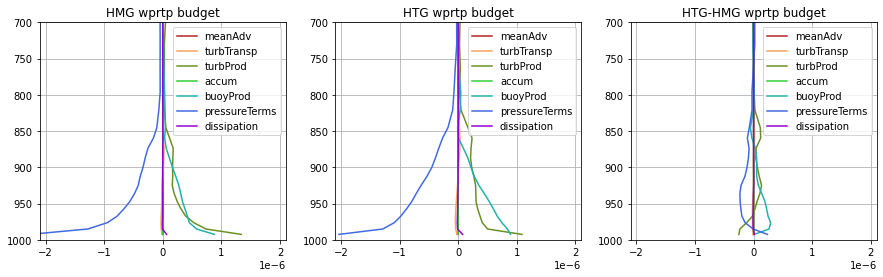

In [21]:
## Artificial surface:
#   TKE decreases most stronly overnight, from maybe 1a to 8a
startHr = 12
endHr   = 15
wprtp_budget_plot(HMGcamDS_localReal_highPct, HTGcamDS_localReal_highPct,
                startHr,endHr,0.21e-5,-0.21e-5)


Means computed over the inclusive period of 12 to 15.


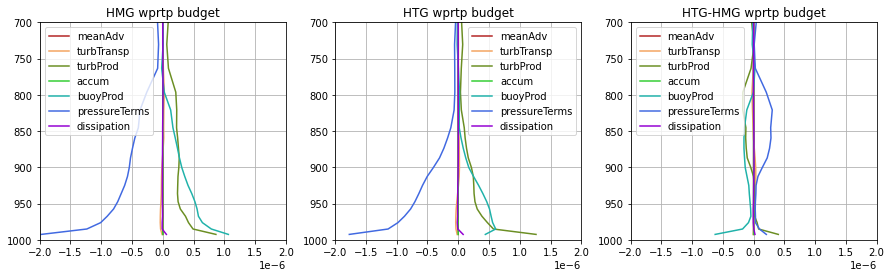

In [22]:
## Artificial surface:
#   TKE decreases most stronly overnight, from maybe 1a to 8a
startHr = 12
endHr   = 15
wprtp_budget_plot(HMGcamDS_localReal_lowPct, HTGcamDS_localReal_lowPct,
                startHr,endHr,0.2e-5,-0.2e-5)


### WPTHLP budget

In [23]:
## Plot budget terms 

def wpthlp_budget_plot(HMGds,HTGds,startHr,endHr,xmax,xmin):
    
    # ------- dDry days ----------
    iTimeSel_dDryHMG = np.where((HMGds["time.hour"].values>=startHr) & 
                                (HMGds["time.hour"].values<=endHr))[0]
    iTimeSel_dDryHTG = np.where((HTGds["time.hour"].values>=startHr) & 
                                (HTGds["time.hour"].values<=endHr))[0]


    hourlyMean_dDryTimeSel_HMG = HMGds.isel(time=iTimeSel_dDryHMG).mean(dim='time')
    hourlyMean_dDryTimeSel_HTG = HTGds.isel(time=iTimeSel_dDryHTG).mean(dim='time')


    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))


    meanAdvHMG        = hourlyMean_dDryTimeSel_HMG['wpthlp_ma'].values[:,0,0]
    turbTranspHMG     = hourlyMean_dDryTimeSel_HMG['wpthlp_ta'].values[:,0,0]
    turbProdHMG       = hourlyMean_dDryTimeSel_HMG['wpthlp_tp'].values[:,0,0]
    accumHMG          = hourlyMean_dDryTimeSel_HMG['wpthlp_ac'].values[:,0,0]
    buoyProdHMG       = hourlyMean_dDryTimeSel_HMG['wpthlp_bp'].values[:,0,0]
    press1HMG         = hourlyMean_dDryTimeSel_HMG['wpthlp_pr1'].values[:,0,0]
    press2HMG         = hourlyMean_dDryTimeSel_HMG['wpthlp_pr2'].values[:,0,0]
    press3HMG         = hourlyMean_dDryTimeSel_HMG['wpthlp_pr3'].values[:,0,0]
    pressureApproxHMG = press1HMG+press2HMG+press3HMG
    dissipationHMG    = hourlyMean_dDryTimeSel_HMG['wpthlp_dp1'].values[:,0,0]

    meanAdvHTG        = hourlyMean_dDryTimeSel_HTG['wpthlp_ma'].values[:,0,0]
    turbTranspHTG     = hourlyMean_dDryTimeSel_HTG['wpthlp_ta'].values[:,0,0]
    turbProdHTG       = hourlyMean_dDryTimeSel_HTG['wpthlp_tp'].values[:,0,0]
    accumHTG          = hourlyMean_dDryTimeSel_HTG['wpthlp_ac'].values[:,0,0]
    buoyProdHTG       = hourlyMean_dDryTimeSel_HTG['wpthlp_bp'].values[:,0,0]
    press1HTG         = hourlyMean_dDryTimeSel_HTG['wpthlp_pr1'].values[:,0,0]
    press2HTG         = hourlyMean_dDryTimeSel_HTG['wpthlp_pr2'].values[:,0,0]
    press3HTG         = hourlyMean_dDryTimeSel_HTG['wpthlp_pr3'].values[:,0,0]
    pressureApproxHTG = press1HTG+press2HTG+press3HTG
    dissipationHTG    = hourlyMean_dDryTimeSel_HTG['wpthlp_dp1'].values[:,0,0]
    
    fig,axs = plt.subplots(1,3, figsize=(15,4))
    axs = axs.ravel()

    colorsList = np.asarray(['firebrick','sandybrown','olivedrab','limegreen','lightseagreen','royalblue','darkviolet'])

    axs[0].plot(meanAdvHMG[0:-1],        HMGds.ilev.values[0:-1], color=colorsList[0], label='meanAdv')
    axs[0].plot(turbTranspHMG[0:-1],     HMGds.ilev.values[0:-1], color=colorsList[1], label='turbTransp')
    axs[0].plot(turbProdHMG[0:-1],       HMGds.ilev.values[0:-1], color=colorsList[2], label='turbProd')
    axs[0].plot(accumHMG[0:-1],          HMGds.ilev.values[0:-1], color=colorsList[3], label='accum')
    axs[0].plot(buoyProdHMG[0:-1],       HMGds.ilev.values[0:-1], color=colorsList[4], label='buoyProd')
    axs[0].plot(pressureApproxHMG[0:-1], HMGds.ilev.values[0:-1], color=colorsList[5], label='pressureTerms')
    axs[0].plot(dissipationHMG[0:-1],    HMGds.ilev.values[0:-1], color=colorsList[6], label='dissipation')
    # axs[0].plot(residualHMG[0:-1],       HMGcamDS_local.ilev.values[0:-1],'ko-', label='residual')

    axs[1].plot(meanAdvHTG[0:-1],        HTGds.ilev.values[0:-1], color=colorsList[0], label='meanAdv')
    axs[1].plot(turbTranspHTG[0:-1],     HTGds.ilev.values[0:-1], color=colorsList[1], label='turbTransp')
    axs[1].plot(turbProdHTG[0:-1],       HTGds.ilev.values[0:-1], color=colorsList[2], label='turbProd')
    axs[1].plot(accumHTG[0:-1],          HTGds.ilev.values[0:-1], color=colorsList[3], label='accum')
    axs[1].plot(buoyProdHTG[0:-1],       HTGds.ilev.values[0:-1], color=colorsList[4], label='buoyProd')
    axs[1].plot(pressureApproxHTG[0:-1], HTGds.ilev.values[0:-1], color=colorsList[5], label='pressureTerms')
    axs[1].plot(dissipationHTG[0:-1],    HTGds.ilev.values[0:-1], color=colorsList[6], label='dissipation')
    # axs[0].plot(residualHMG[0:-1],       HMGcamDS_local.ilev.values[0:-1],'ko-', label='residual')


    # Plot difference
    axs[2].plot(meanAdvHTG[0:-1]-meanAdvHMG[0:-1],              HTGds.ilev.values[0:-1], color=colorsList[0], label='meanAdv')
    axs[2].plot(turbTranspHTG[0:-1]-turbTranspHMG[0:-1],        HTGds.ilev.values[0:-1], color=colorsList[1], label='turbTransp')
    axs[2].plot(turbProdHTG[0:-1]-turbProdHMG[0:-1],            HTGds.ilev.values[0:-1], color=colorsList[2], label='turbProd')
    axs[2].plot(accumHTG[0:-1]-accumHMG[0:-1],                  HTGds.ilev.values[0:-1], color=colorsList[3], label='accum')
    axs[2].plot(buoyProdHTG[0:-1]-buoyProdHMG[0:-1],            HTGds.ilev.values[0:-1], color=colorsList[4], label='buoyProd')
    axs[2].plot(pressureApproxHTG[0:-1]-pressureApproxHMG[0:-1], HTGds.ilev.values[0:-1], color=colorsList[5], label='pressureTerms')
    axs[2].plot(dissipationHTG[0:-1]-dissipationHMG[0:-1],      HTGds.ilev.values[0:-1], color=colorsList[6], label='dissipation')
    
    # Consistent settings across subplots 
    axs[0].set_ylim([700,1000])
    axs[0].set_xlim([xmin,xmax])
    axs[0].invert_yaxis()
    axs[0].legend()
    axs[0].set_title('HMG wpthlp budget')

    axs[1].set_ylim([700,1000])
    axs[1].set_xlim([xmin,xmax])
    axs[1].invert_yaxis()
    axs[1].legend()
    axs[1].set_title('HTG wpthlp budget')

    axs[2].set_ylim([700,1000])
    axs[2].set_xlim([xmin,xmax])
    axs[2].invert_yaxis()
    axs[2].legend()
    axs[2].set_title('HTG-HMG wpthlp budget')
    
    axs[0].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[1].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[2].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    
    axs[0].grid()
    axs[1].grid()
    axs[2].grid()
    
    return



In [24]:
## Add other vars to the list

# This set uses theta, not theta_v; and adds outputs of rt'thv' and tau
dataDir      = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/realSfc_buoyancyTau_useTheta/'
caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_plusBuoyancyTau_useTheta_'
caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_plusBuoyancyTau_useTheta_'

yearStrings  = np.asarray(['2015','2016','2017','2018'])

fileCount=0
for iYr in range(len(yearStrings)): 

    fileStart_atm_HMG   = dataDir+caseName_HMG+yearStrings[iYr]+'jja.cam.h0.'
    fileStart_atm_HTG   = dataDir+caseName_HTG+yearStrings[iYr]+'jja.cam.h0.'

    fileName_atm_HMG   = fileStart_atm_HMG+'wpthlpBudgetTerms.nc'
    fileName_atm_HTG   = fileStart_atm_HTG+'wpthlpBudgetTerms.nc'
    
        
    with xr.open_dataset(fileName_atm_HMG, decode_times=False) as HMG_camDS:
        HMG_camDS = cesm_correct_time(HMG_camDS)
        HMG_camDS['time'] = HMG_camDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(fileName_atm_HTG, decode_times=False) as HTG_camDS:
        HTG_camDS = cesm_correct_time(HTG_camDS)
        HTG_camDS['time'] = HTG_camDS.indexes['time'].to_datetimeindex()  

            
    # Discard first two days 
    iTimeStart   = np.where(HMG_camDS.time.values >= (HMG_camDS.time.values[0] + np.timedelta64(2,'D')))[0]
    timeArr      = np.arange(iTimeStart[0], len(HMG_camDS.time.values))

    HTG_camDS      = HTG_camDS.isel(time=timeArr)
    HMG_camDS      = HMG_camDS.isel(time=timeArr)


    if fileCount==0:
        HTGcamDS_realSfcExtra   = HTG_camDS
        HMGcamDS_realSfcExtra   = HMG_camDS  
    else: 
        HTGcamDS_realSfcExtra   = xr.concat([HTGcamDS_realSfcExtra,HTG_camDS], dim='time')
        HMGcamDS_realSfcExtra   = xr.concat([HMGcamDS_realSfcExtra,HMG_camDS], dim='time')
            
    fileCount = fileCount+1
    print('Done with file %i of %i '% (fileCount,len(yearStrings)))


Done with file 1 of 4 
Done with file 2 of 4 
Done with file 3 of 4 
Done with file 4 of 4 


In [25]:
## Convert to local times...
HTGcamDS_realSfcExtra_local   = HTGcamDS_realSfcExtra.copy(deep=True)
HMGcamDS_realSfcExtra_local   = HMGcamDS_realSfcExtra.copy(deep=True)

# Confirmed that all the times are identical, so using the same local time arrays
localTimes = HMGcamDS_realSfcExtra_local['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
HTGcamDS_realSfcExtra_local = HTGcamDS_realSfcExtra_local.assign_coords({"time": localTimes})
HMGcamDS_realSfcExtra_local = HMGcamDS_realSfcExtra_local.assign_coords({"time": localTimes})



In [26]:
# Merge into larger dataset
HTGcamDS_localReal   = xr.merge([realSfc_allCases.isel(case=1),   HTGcamDS_realSfcExtra_local])
HMGcamDS_localReal   = xr.merge([realSfc_allCases.isel(case=0),   HMGcamDS_realSfcExtra_local])


In [27]:
# Add month_day index to arrays
month_day_idx                      = pd.MultiIndex.from_arrays([HMGclmDS_localReal['time.year'].values,
                                                                HMGclmDS_localReal['time.month'].values, 
                                                                HMGclmDS_localReal['time.day'].values])



HTGcamDS_localReal.coords['year_month_day'] = ('time', month_day_idx)
HMGcamDS_localReal.coords['year_month_day'] = ('time', month_day_idx)

# HTGcamDS_localArt.coords['year_month_day'] = ('time', month_day_idx)
# HMGcamDS_localArt.coords['year_month_day'] = ('time', month_day_idx)


In [28]:
numDays_highPct = len(np.where(np.isfinite(cssDS['pos.month']))[0])
numDays_lowPct  = len(np.where(np.isfinite(cssDS['neg.month']))[0])

iTimes_highPct = []
for iTime in range(numDays_highPct):
    iKeepTimes = np.where((HMGcamDS_localReal['time.year'] ==cssDS['pos.year'].values[iTime]) &
                          (HMGcamDS_localReal['time.month']==cssDS['pos.month'].values[iTime]) & 
                          (HMGcamDS_localReal['time.day']  ==cssDS['pos.day'].values[iTime]))[0]    
    iTimes_highPct = np.append(iTimes_highPct, iKeepTimes).astype(int)

# Now select only those times in the local time array
HMGcamDS_localReal_highPct = HMGcamDS_localReal.isel(time=iTimes_highPct)
HTGcamDS_localReal_highPct = HTGcamDS_localReal.isel(time=iTimes_highPct)


iTimes_lowPct = []
for iTime in range(numDays_lowPct):
    iKeepTimes = np.where((HMGcamDS_localReal['time.year'] ==cssDS['neg.year'].values[iTime]) &
                          (HMGcamDS_localReal['time.month']==cssDS['neg.month'].values[iTime]) & 
                          (HMGcamDS_localReal['time.day']  ==cssDS['neg.day'].values[iTime]))[0]    
    iTimes_lowPct = np.append(iTimes_lowPct, iKeepTimes).astype(int)

# Now select only those times in the local time array
HMGcamDS_localReal_lowPct = HMGcamDS_localReal.isel(time=iTimes_lowPct)
HTGcamDS_localReal_lowPct = HTGcamDS_localReal.isel(time=iTimes_lowPct)


Means computed over the inclusive period of 12 to 15.


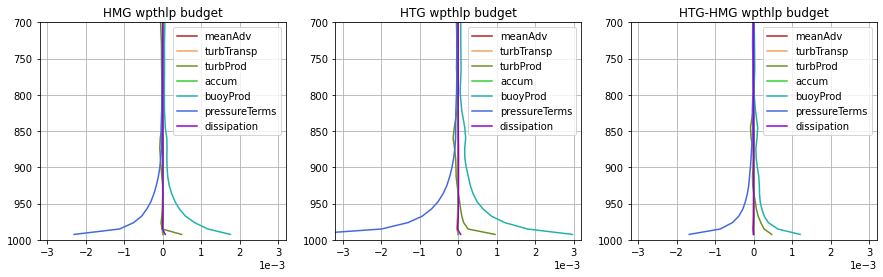

In [38]:
## Artificial surface:
#   TKE decreases most stronly overnight, from maybe 1a to 8a
startHr = 12
endHr   = 15
wpthlp_budget_plot(HMGcamDS_localReal_highPct, HTGcamDS_localReal_highPct,
                startHr,endHr,0.32e-2,-0.32e-2)


Means computed over the inclusive period of 12 to 15.


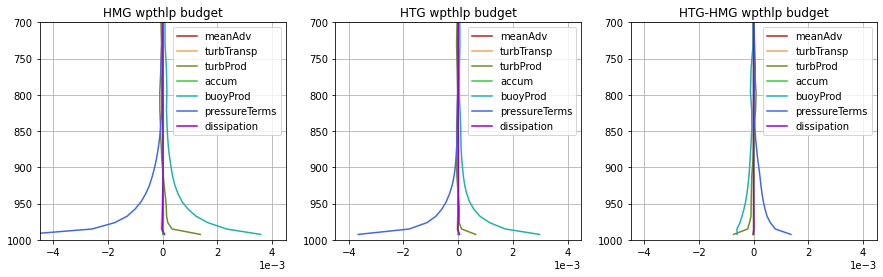

In [41]:
## Artificial surface:
#   TKE decreases most stronly overnight, from maybe 1a to 8a
startHr = 12
endHr   = 15
wpthlp_budget_plot(HMGcamDS_localReal_lowPct, HTGcamDS_localReal_lowPct,
                startHr,endHr,0.45e-2,-0.45e-2)


### OLD: Identify wet/dry days

In [28]:
'''
Find all the times in the full array (20m dt) that line up with the day classifications above. 
'''
def getTimes_basedOnDayClass(fullDS, dayClassDS):
    iTimes = []
    
    for iTime in range(len(dayClassDS.year_month_day.values)):
        iKeepTimes = np.where((fullDS['time.year'] ==dayClassDS.year_month_day_level_0.values[iTime]) &
                              (fullDS['time.month']==dayClassDS.year_month_day_level_1.values[iTime]) & 
                              (fullDS['time.day']  ==dayClassDS.year_month_day_level_2.values[iTime]))[0]    
        iTimes = np.append(iTimes, iKeepTimes).astype(int)
    
    # Now select only those times in the local time array
    DS_dayClass = fullDS.isel(time=iTimes)
    
    return(DS_dayClass)



In [29]:
import pickle 

## Load wet/dry day arrays from pickle file (saved 11/3/2021)
saveDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/ProcessedFiles/'

artSfc_allCasesDailySum_dDry        = pickle.load( open( saveDir+"artSfc_allCasesDailySum_dDry.p", "rb" ) )
artSfc_allCasesDailySum_wWet        = pickle.load( open( saveDir+"artSfc_allCasesDailySum_wWet.p", "rb" ) )



In [30]:
dDryDays_HMGlocal          = getTimes_basedOnDayClass(HMGcamDS_localArt,      artSfc_allCasesDailySum_dDry)
dDryDays_HTGlocal          = getTimes_basedOnDayClass(HTGcamDS_localArt,      artSfc_allCasesDailySum_dDry)
dDryDays_HMGlocalReal      = getTimes_basedOnDayClass(HMGcamDS_localReal,      artSfc_allCasesDailySum_dDry)
dDryDays_HTGlocalReal      = getTimes_basedOnDayClass(HTGcamDS_localReal,      artSfc_allCasesDailySum_dDry)


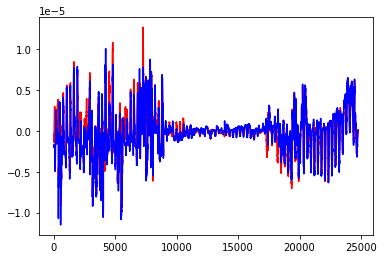

In [31]:
plt.plot(dDryDays_HMGlocal.wp2_ma.values[:,-2,0,0], 'r')
plt.plot(dDryDays_HTGlocal.wp2_ma.values[:,-2,0,0], 'b')

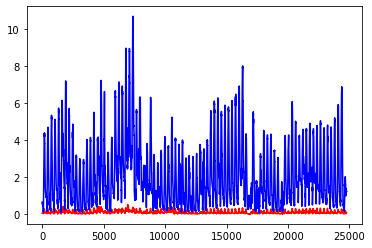

In [20]:
plt.plot(dDryDays_HMGlocal.THLP2_CLUBB.values[:,-1,0,0], 'r')
plt.plot(dDryDays_HTGlocal.THLP2_CLUBB.values[:,-1,0,0], 'b')

## Now make some plots

In [39]:
## Plot budget terms 

def wp2_budget_plot(HMGds,HTGds,startHr,endHr,xmax,xmin):
    
    # ------- dDry days ----------
    iTimeSel_dDryHMG = np.where((HMGds["time.hour"].values>=startHr) & 
                                (HMGds["time.hour"].values<=endHr))[0]
    iTimeSel_dDryHTG = np.where((HTGds["time.hour"].values>=startHr) & 
                                (HTGds["time.hour"].values<=endHr))[0]


    hourlyMean_dDryTimeSel_HMG = HMGds.isel(time=iTimeSel_dDryHMG).mean(dim='time')
    hourlyMean_dDryTimeSel_HTG = HTGds.isel(time=iTimeSel_dDryHTG).mean(dim='time')


    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))


    meanAdvHMG        = hourlyMean_dDryTimeSel_HMG['wp2_ma'].values[:,0,0]
    turbTranspHMG     = hourlyMean_dDryTimeSel_HMG['wp2_ta'].values[:,0,0]
    accumHMG          = hourlyMean_dDryTimeSel_HMG['wp2_ac'].values[:,0,0]
    buoyProdHMG       = hourlyMean_dDryTimeSel_HMG['wp2_bp'].values[:,0,0]
    
    press1HMG         = hourlyMean_dDryTimeSel_HMG['wp2_pr1'].values[:,0,0]
    press2HMG         = hourlyMean_dDryTimeSel_HMG['wp2_pr2'].values[:,0,0]
    press3HMG         = hourlyMean_dDryTimeSel_HMG['wp2_pr3'].values[:,0,0]
    pressureApproxHMG = press1HMG+press2HMG+press3HMG
    
    dissipation1HMG    = hourlyMean_dDryTimeSel_HMG['wp2_dp1'].values[:,0,0]
    dissipation2HMG    = hourlyMean_dDryTimeSel_HMG['wp2_dp2'].values[:,0,0]
    dissipationHMG     = dissipation1HMG + dissipation2HMG

    dwprtpdtHMG = hourlyMean_dDryTimeSel_HMG['wp2_bt'].values[:,0,0]
    sumTermsHMG = meanAdvHMG + turbTranspHMG  + accumHMG + buoyProdHMG + pressureApproxHMG + dissipationHMG

    residualHMG = dwprtpdtHMG - sumTermsHMG

    
    

    meanAdvHTG        = hourlyMean_dDryTimeSel_HTG['wp2_ma'].values[:,0,0]
    turbTranspHTG     = hourlyMean_dDryTimeSel_HTG['wp2_ta'].values[:,0,0]
    accumHTG          = hourlyMean_dDryTimeSel_HTG['wp2_ac'].values[:,0,0]
    buoyProdHTG       = hourlyMean_dDryTimeSel_HTG['wp2_bp'].values[:,0,0]
    
    press1HTG         = hourlyMean_dDryTimeSel_HTG['wp2_pr1'].values[:,0,0]
    press2HTG         = hourlyMean_dDryTimeSel_HTG['wp2_pr2'].values[:,0,0]
    press3HTG         = hourlyMean_dDryTimeSel_HTG['wp2_pr3'].values[:,0,0]
    pressureApproxHTG = press1HTG+press2HTG+press3HTG
    
    dissipation1HTG    = hourlyMean_dDryTimeSel_HTG['wp2_dp1'].values[:,0,0]
    dissipation2HTG    = hourlyMean_dDryTimeSel_HTG['wp2_dp2'].values[:,0,0]
    dissipationHTG     = dissipation1HTG + dissipation2HTG

    dwprtpdtHTG = hourlyMean_dDryTimeSel_HTG['wp2_bt'].values[:,0,0]
    sumTermsHTG = meanAdvHTG + turbTranspHTG + accumHTG + buoyProdHTG + pressureApproxHTG + dissipationHTG

    residualHTG = dwprtpdtHTG - sumTermsHTG
    
    
    fig,axs = plt.subplots(1,3, figsize=(15,4))
    axs = axs.ravel()

    colorsList = np.asarray(['firebrick','sandybrown','olivedrab','limegreen','lightseagreen','royalblue','darkviolet'])

    axs[0].plot(meanAdvHMG[0:-1],        HMGds.ilev.values[0:-1], color=colorsList[0], label='meanAdv')
    axs[0].plot(turbTranspHMG[0:-1],     HMGds.ilev.values[0:-1], color=colorsList[1], label='turbTransp')
    axs[0].plot(accumHMG[0:-1],          HMGds.ilev.values[0:-1], color=colorsList[3], label='accum')
    axs[0].plot(buoyProdHMG[0:-1],       HMGds.ilev.values[0:-1], color=colorsList[4], label='buoyProd')
    axs[0].plot(pressureApproxHMG[0:-1], HMGds.ilev.values[0:-1], color=colorsList[5], label='pressureTerms')
    axs[0].plot(dissipationHMG[0:-1],    HMGds.ilev.values[0:-1], color=colorsList[6], label='dissipation')
    # axs[0].plot(residualHMG[0:-1],       HMGcamDS_local.ilev.values[0:-1],'ko-', label='residual')

    axs[1].plot(meanAdvHTG[0:-1],        HTGds.ilev.values[0:-1], color=colorsList[0], label='meanAdv')
    axs[1].plot(turbTranspHTG[0:-1],     HTGds.ilev.values[0:-1], color=colorsList[1], label='turbTransp')
    axs[1].plot(accumHTG[0:-1],          HTGds.ilev.values[0:-1], color=colorsList[3], label='accum')
    axs[1].plot(buoyProdHTG[0:-1],       HTGds.ilev.values[0:-1], color=colorsList[4], label='buoyProd')
    axs[1].plot(pressureApproxHTG[0:-1], HTGds.ilev.values[0:-1], color=colorsList[5], label='pressureTerms')
    axs[1].plot(dissipationHTG[0:-1],    HTGds.ilev.values[0:-1], color=colorsList[6], label='dissipation')
    # axs[0].plot(residualHMG[0:-1],       HMGcamDS_local.ilev.values[0:-1],'ko-', label='residual')


    # Plot difference
    axs[2].plot(meanAdvHTG[0:-1]-meanAdvHMG[0:-1],              HTGds.ilev.values[0:-1], color=colorsList[0], label='meanAdv')
    axs[2].plot(turbTranspHTG[0:-1]-turbTranspHMG[0:-1],        HTGds.ilev.values[0:-1], color=colorsList[1], label='turbTransp')
    axs[2].plot(accumHTG[0:-1]-accumHMG[0:-1],                  HTGds.ilev.values[0:-1], color=colorsList[3], label='accum')
    axs[2].plot(buoyProdHTG[0:-1]-buoyProdHMG[0:-1],            HTGds.ilev.values[0:-1], color=colorsList[4], label='buoyProd')
    axs[2].plot(pressureApproxHTG[0:-1]-pressureApproxHMG[0:-1], HTGds.ilev.values[0:-1], color=colorsList[5], label='pressureTerms')
    axs[2].plot(dissipationHTG[0:-1]-dissipationHMG[0:-1],      HTGds.ilev.values[0:-1], color=colorsList[6], label='dissipation')
    
    # Consistent settings across subplots 
    axs[0].set_ylim([700,1000])
    axs[0].set_xlim([xmin,xmax])
    axs[0].invert_yaxis()
    axs[0].legend()
    axs[0].set_title('HMG wp2 budget')

    axs[1].set_ylim([700,1000])
    axs[1].set_xlim([xmin,xmax])
    axs[1].invert_yaxis()
    axs[1].legend()
    axs[1].set_title('HTG wp2 budget')

    axs[2].set_ylim([700,1000])
    axs[2].set_xlim([xmin,xmax])
    axs[2].invert_yaxis()
    axs[2].legend()
    axs[2].set_title('HTG-HMG wp2 budget')
    
    
    axs[0].grid()
    axs[1].grid()
    axs[2].grid()
    
    return



Means computed over the inclusive period of 1 to 8.


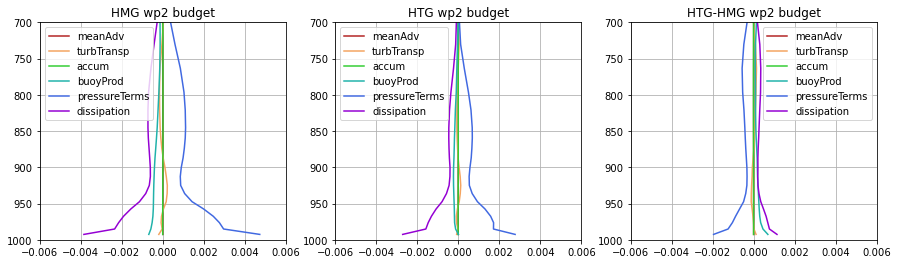

In [40]:
## Artificial surface:
#   TKE decreases most stronly overnight, from maybe 1a to 8a
startHr = 1
endHr   = 8
wp2_budget_plot(dDryDays_HMGlocal,dDryDays_HTGlocal,startHr,endHr,0.006,-0.006)


In [41]:
# ## Artificial surface:
# #   TKE decreases most stronly overnight, from maybe 1a to 8a
# startHr = 15
# endHr   = 19
# wp2_budget_plot(dDryDays_HMGlocal,dDryDays_HTGlocal,startHr,endHr,0.02,-0.02)


Means computed over the inclusive period of 15 to 19.


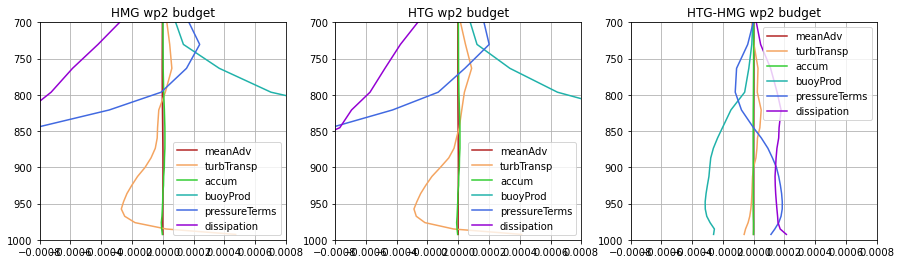

In [45]:
## Real surface
#   TKE seems to decrease most from about 3p to 6p 
startHr = 15
endHr   = 19
wp2_budget_plot(dDryDays_HMGlocalReal,dDryDays_HTGlocalReal,startHr,endHr,0.0008,-0.0008)


Also plot mean WP2 profiles over same period

In [22]:
def plotProfiles(HMGds,HTGds,varSel,startHr,endHr,xmax,xmin):
    # ------- dDry days ----------
    iTimeSel_dDryHMG = np.where((HMGds["time.hour"].values>=startHr) & 
                                (HMGds["time.hour"].values<=endHr))[0]
    iTimeSel_dDryHTG = np.where((HTGds["time.hour"].values>=startHr) & 
                                (HTGds["time.hour"].values<=endHr))[0]


    hourlyMean_dDryTimeSel_HMG = HMGds.isel(time=iTimeSel_dDryHMG).mean(dim='time')
    hourlyMean_dDryTimeSel_HTG = HTGds.isel(time=iTimeSel_dDryHTG).mean(dim='time')
    
    
    fig,axs = plt.subplots(1,1, figsize=(6,4))

    axs.plot(hourlyMean_dDryTimeSel_HMG[varSel].values[:,0,0], hourlyMean_dDryTimeSel_HMG.ilev.values, 'r', label='HMG')
    axs.plot(hourlyMean_dDryTimeSel_HTG[varSel].values[:,0,0], hourlyMean_dDryTimeSel_HTG.ilev.values, 'b', label='HTG')
    
    axs.legend()
    
    axs.set_ylim([700,1000])
    axs.invert_yaxis()
    axs.set_xlim([xmin,xmax])
    
    
    return
    

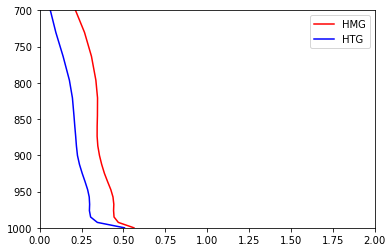

In [25]:
## Artificial surface:
#   TKE decreases most stronly overnight, from maybe 1a to 8a
startHr = 1
endHr   = 8
plotProfiles(dDryDays_HMGlocal,dDryDays_HTGlocal,'WP2_CLUBB',startHr,endHr,2,0)

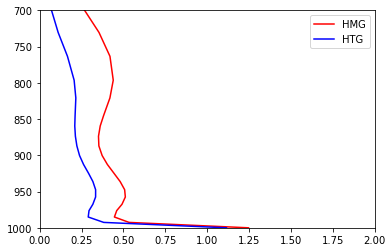

In [26]:
## Artificial surface:
#   TKE decreases most stronly overnight, from maybe 1a to 8a
startHr = 1
endHr   = 8
plotProfiles(dDryDays_HMGlocal,dDryDays_HTGlocal,'UP2_CLUBB',startHr,endHr,2,0)

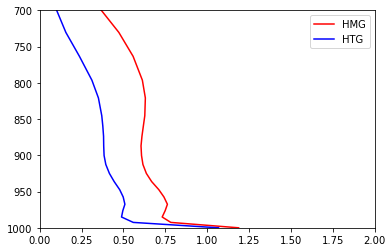

In [23]:
## Artificial surface:
#   TKE decreases most stronly overnight, from maybe 1a to 8a
startHr = 1
endHr   = 8
plotProfiles(dDryDays_HMGlocal,dDryDays_HTGlocal,'TKE',startHr,endHr,2,0)

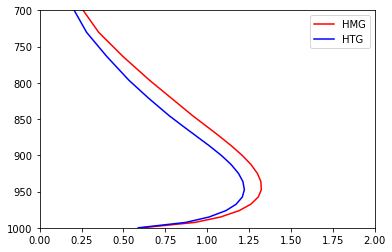

In [24]:
## Real surface
#   TKE seems to decrease most from about 3p to 6p 
startHr = 15
endHr   = 19

plotProfiles(dDryDays_HMGlocalReal,dDryDays_HTGlocalReal,'WP2_CLUBB',startHr,endHr,2,0)

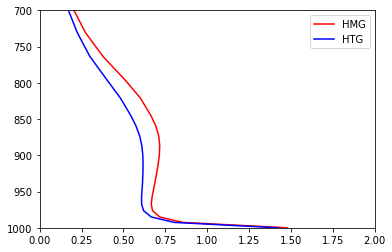

In [25]:
## Real surface
#   TKE seems to decrease most from about 3p to 6p 
startHr = 15
endHr   = 19

plotProfiles(dDryDays_HMGlocalReal,dDryDays_HTGlocalReal,'UP2_CLUBB',startHr,endHr,2,0)

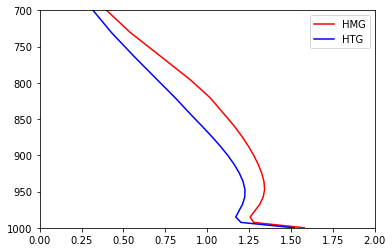

In [32]:
## Real surface
#   TKE seems to decrease most from about 3p to 6p 
startHr = 15
endHr   = 19

plotProfiles(dDryDays_HMGlocalReal,dDryDays_HTGlocalReal,'TKE',startHr,endHr,2,0)